# BiRank Algorithm

## Data 

In [1]:
import numpy as np
import scipy as sp
import pickle as pkl
import networkx as nx
from py2neo import Graph
import py2neo
import pandas as pd
import nxviz as nv
import matplotlib.pyplot as plt
from stellargraph import StellarGraph
from sklearn.metrics import precision_recall_curve

from tqdm.notebook import tqdm


%matplotlib inline

C:\Users\bruno\anaconda3\lib\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.0 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.0, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [2]:
from BiRank import BiRank

In [3]:
broker_nodes = pkl.load(open( "broker_nodes_brunosept.pkl", "rb" ))
cars_nodes = pkl.load(open( "cars_nodes_brunosept.pkl", "rb" ))
claims_nodes = pkl.load(open( "claims_nodes_brunosept.pkl", "rb" )).sort_values("ID")
policy_nodes = pkl.load(open( "policy_nodes_brunosept.pkl", "rb" ))
edges = pkl.load(open( "edges_brunosept.pkl", "rb" ))

labels = pd.DataFrame(pkl.load(open("Y", "rb"))).sort_values("SI01_NO_SIN")
labels.rename(columns = {"y1": "Fraud", "y2":"Labelled"}, inplace = True)

In [8]:
HG = StellarGraph({"claim" : claims_nodes, "car" : cars_nodes, "policy" : policy_nodes, "broker" : broker_nodes}, edges)

j = 0
nodes = []
for i in HG.connected_components():
    if j == 0:
        nodes.append(i)
    else: 
        break

nodes_largest_con_comp = nodes[0]

HG = HG.subgraph(nodes_largest_con_comp); HG.nodes("claim")

array(['000020111059354', '000020111059939', '000020121000009', ...,
       '000020211007108', '000020211007109', '000020211007111'],
      dtype=object)

In [9]:
labels = labels[labels.index.isin(HG.nodes("claim"))]

## Adjacency Matrix

In [12]:
HG_claims = HG.nodes("claim")
HG_cars = HG.nodes("car")
HG_sub = list(HG_claims)+ list(HG_cars)
adjmat_claim_car = HG.to_adjacency_matrix(HG_sub)[:len(HG_claims), len(HG_claims):]

HG_policies = HG.nodes("policy")
HG_sub = list(HG_cars)+list(HG_policies)
adjmat_car_policy = HG.to_adjacency_matrix(HG_sub)[:len(HG_cars), len(HG_cars):]

HG_brokers = HG.nodes("broker")
HG_sub = list(HG_policies) + list(HG_brokers)
adjmat_policy_broker = HG.to_adjacency_matrix(HG_sub)[:len(HG_policies), len(HG_policies):]

In [13]:
HG_claims

array(['000020111059354', '000020111059939', '000020121000009', ...,
       '000020211007108', '000020211007109', '000020211007111'],
      dtype=object)

In [14]:
C = adjmat_claim_car
P = adjmat_car_policy
B = adjmat_policy_broker
CP = C @ P
CB = CP @ B

adjmat_bipartite = sp.sparse.hstack((C, CP, CB))

## Fraud labels

In [15]:
fraud = {"FraudInd": labels["Fraud"].values}
fraudMat = pd.DataFrame(fraud)

claim_nodes = pd.DataFrame({"ID": HG_claims}).set_index("ID")

HG_parties = np.concatenate((HG_cars, HG_policies, HG_brokers))
party_nodes = pd.DataFrame({"ID": HG_parties}).set_index("ID")

ADJ = adjmat_bipartite.transpose().tocsr()

In [16]:
Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, claim_nodes, party_nodes, fraudMat)

C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.


In [17]:
print(Claims_res.head().to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &      ID &     Score &   StdScore &  ScaledScore \\
\midrule
59872  &   59872 &  0.000691 &  38.869349 &     1.000000 \\
55116  &   55116 &  0.000690 &  38.808654 &     0.998443 \\
105980 &  105980 &  0.000688 &  38.709495 &     0.995900 \\
86863  &   86863 &  0.000640 &  36.016585 &     0.926831 \\
126178 &  126178 &  0.000640 &  35.998055 &     0.926356 \\
\bottomrule
\end{tabular}



In [18]:
fraudsters = labels
fraudsters = pd.DataFrame(fraudsters)
fraudsters["ID"] = range(len(labels.index))

claims_merged = pd.merge(Claims_res, fraudsters, on = "ID")
claims_merged[claims_merged["Fraud"]==0].head(10)

,ID,Score,StdScore,ScaledScore,Fraud,Labelled
774,41260,0.000218,12.162676,0.315016,0,0.0
777,142357,0.000215,12.002447,0.310906,0,0.0
786,41267,0.000210,11.718923,0.303634,0,0.0
792,196172,0.000202,11.267767,0.292063,0,0.0
808,223676,0.000187,10.442149,0.270887,0,0.0
809,201997,0.000187,10.412901,0.270137,0,0.0
810,179822,0.000186,10.391016,0.269576,0,0.0
811,180643,0.000183,10.206540,0.264844,0,1.0
812,352044,0.000183,10.185405,0.264302,0,1.0
813,279678,0.000177,9.843192,0.255525,0,0.0


In [19]:
print(claims_merged[claims_merged["Fraud"]==0].head().to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &      ID &     Score &   StdScore &  ScaledScore &  Fraud &  Labelled \\
\midrule
774 &   41260 &  0.000218 &  12.162676 &     0.315016 &      0 &       0.0 \\
777 &  142357 &  0.000215 &  12.002447 &     0.310906 &      0 &       0.0 \\
786 &   41267 &  0.000210 &  11.718923 &     0.303634 &      0 &       0.0 \\
792 &  196172 &  0.000202 &  11.267767 &     0.292063 &      0 &       0.0 \\
808 &  223676 &  0.000187 &  10.442149 &     0.270887 &      0 &       0.0 \\
\bottomrule
\end{tabular}



In [20]:
claim_nodes.iloc[703] #highest fraud

Series([], Name: 000020121000970, dtype: float64)

In [21]:
claim_nodes.iloc[116408] #with brokers

Series([], Name: 000020141033072, dtype: float64)

In [22]:
claim_nodes.iloc[122134] #with brokers

Series([], Name: 000020141041214, dtype: float64)

In [23]:
claim_nodes.iloc[38447] #with brokers

Series([], Name: 000020121052243, dtype: float64)

In [24]:
claim_nodes.iloc[43645] #without brokers

Series([], Name: 000020121059586, dtype: float64)

In [25]:
claim_nodes.iloc[367463] #without brokers

Series([], Name: 000020201023664, dtype: float64)

In [26]:
from sklearn import metrics

Text(0.5, 1.0, 'AUC: 1.0')

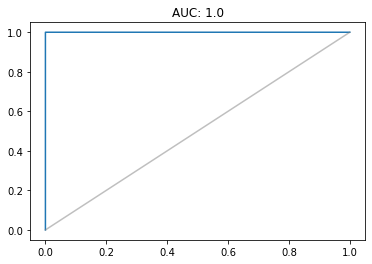

In [27]:
from sklearn import metrics
y = labels.Fraud.values
pred = Claims_res.sort_values("ID").ScaledScore

fpr, tpr, thresholds = metrics.roc_curve(y,pred)

plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr, tpr),3)))

Text(0.5, 1.0, 'Average Precision: 1.0')

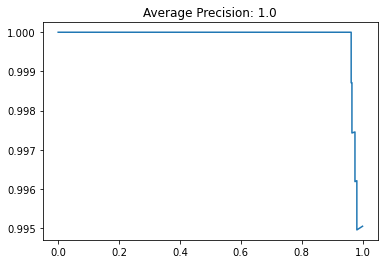

In [29]:
precision, recall, thresholds = precision_recall_curve(y, pred)
plt.plot(recall,precision)
plt.title("Average Precision: "+str(np.round(metrics.average_precision_score(y, pred),3)))

In [30]:
ADJ = adjmat_bipartite.tocsr()
number_claims = ADJ.shape[0]
train_set_size = int(np.round(0.6*number_claims))
test_set_size = number_claims-train_set_size
ADJ_train= ADJ[:train_set_size,:]
fraud_train = {"FraudInd": labels["Fraud"].values[:train_set_size]}
fraudMat_train = pd.DataFrame(fraud_train)
claims_train = claim_nodes[:train_set_size]

ADJ = ADJ_train.transpose().tocsr()
Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, claims_train, party_nodes, fraudMat_train)

fraud_train_res = {"FraudInd": Claims_res.sort_values("ID")["ScaledScore"].values}
test_set_fraud = {"FraudInd": [0]*test_set_size}
fraudMat_train_res = pd.DataFrame(fraud_train_res)
fraudMat_test_set = pd.DataFrame(test_set_fraud)
fraudMat_test = fraudMat_train_res.append(fraudMat_test_set)

ADJ = adjmat_bipartite.transpose().tocsr()
Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, claim_nodes, party_nodes, fraudMat_test)

C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.
Convergence reached.


In [31]:
#ths = [8**(-x) for x in range(3,6)]
#ths.append(0); ths

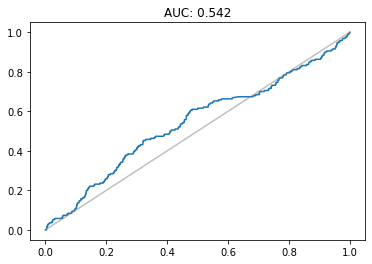

In [32]:
y = labels[train_set_size:].Fraud.values
pred = Claims_res.sort_values("ID")[train_set_size:].ScaledScore
fpr, tpr, thresholds = metrics.roc_curve(y,pred)

plt.plot(fpr,tpr)

#for i in range(len(ths)-1):
#    fp = fpr[(thresholds<ths[i])&(thresholds>ths[i+1])]
#    tp = tpr[(thresholds<ths[i])&(thresholds>ths[i+1])]
#    plt.plot(fp, tp)

plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr, tpr),3)))
plt.savefig("AUC_Inductive_Connected.pdf")

Text(0.5, 1.0, 'Average Precision: 0.002')

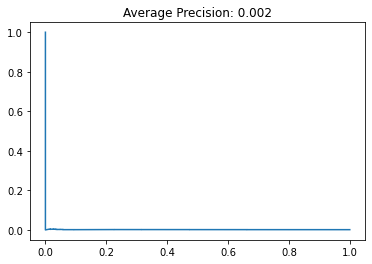

In [33]:
precision, recall, thresholds = precision_recall_curve(y, pred)
plt.plot(recall,precision)
plt.title("Average Precision: "+str(np.round(metrics.average_precision_score(y, pred),3)))

C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.


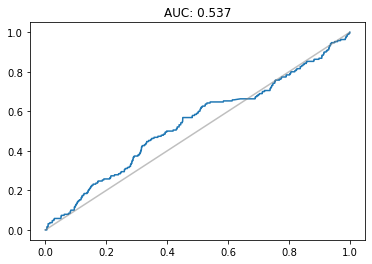

In [34]:
fraud_train = {"FraudInd": labels["Fraud"].values[:train_set_size]}
fraudMat_train = pd.DataFrame(fraud_train)
test_set_fraud = {"FraudInd": [0]*test_set_size}
fraudMat_test_set = pd.DataFrame(test_set_fraud)
fraudMat_test = fraudMat_train.append(fraudMat_test_set)

ADJ = adjmat_bipartite.transpose().tocsr()
Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, claim_nodes, party_nodes, fraudMat_test)

y = labels[train_set_size:].Fraud.values
pred = Claims_res.sort_values("ID")[train_set_size:].ScaledScore
fpr, tpr, thresholds = metrics.roc_curve(y,pred)
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr, tpr),3)))
plt.savefig("AUC_Transductive_Connected.pdf")

Text(0.5, 1.0, 'Average Precision: 0.002')

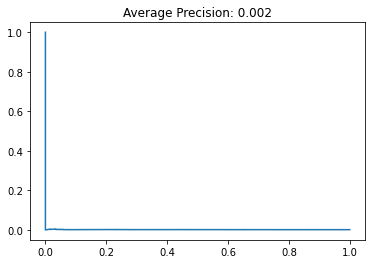

In [35]:
precision, recall, thresholds = precision_recall_curve(y, pred)
plt.plot(recall,precision)
plt.title("Average Precision: "+str(np.round(metrics.average_precision_score(y, pred),3)))

In [36]:
print(Claims_res.head().to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &      ID &     Score &   StdScore &  ScaledScore \\
\midrule
59872  &   59872 &  0.000905 &  44.230053 &     1.000000 \\
55116  &   55116 &  0.000903 &  44.160157 &     0.998423 \\
105980 &  105980 &  0.000901 &  44.033666 &     0.995570 \\
86863  &   86863 &  0.000838 &  40.981114 &     0.926716 \\
126178 &  126178 &  0.000838 &  40.963499 &     0.926318 \\
\bottomrule
\end{tabular}



## Labelled

C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.


Text(0.5, 1.0, 'AUC: 0.986')

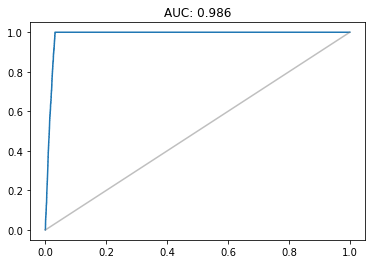

In [37]:
fraud = {"FraudInd": labels["Labelled"].values}
fraudMat = pd.DataFrame(fraud)

claim_nodes = pd.DataFrame({"ID": HG_claims}).set_index("ID")

HG_parties = np.concatenate((HG_cars, HG_policies, HG_brokers))
party_nodes = pd.DataFrame({"ID": HG_parties}).set_index("ID")

ADJ = adjmat_bipartite.transpose().tocsr()

Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, claim_nodes, party_nodes, fraudMat)

fraudsters = labels
fraudsters = pd.DataFrame(fraudsters)
fraudsters["ID"] = range(len(labels.index))

y = labels.Fraud.values
pred = Claims_res.sort_values("ID").ScaledScore

fpr, tpr, thresholds = metrics.roc_curve(y,pred)

plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr, tpr),3)))

C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.
Convergence reached.


Text(0.5, 1.0, 'AUC: 0.53')

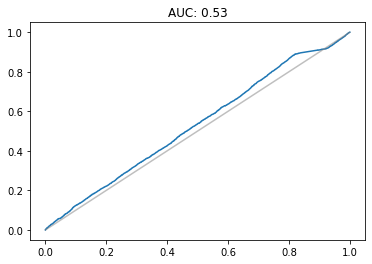

In [38]:
ADJ = adjmat_bipartite.tocsr()
number_claims = ADJ.shape[0]
train_set_size = int(np.round(0.6*number_claims))
test_set_size = number_claims-train_set_size
ADJ_train= ADJ[:train_set_size,:]
fraud_train = {"FraudInd": labels["Labelled"].values[:train_set_size]}
fraudMat_train = pd.DataFrame(fraud_train)
claims_train = claim_nodes[:train_set_size]

ADJ = ADJ_train.transpose().tocsr()
Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, claims_train, party_nodes, fraudMat_train)

fraud_train_res = {"FraudInd": Claims_res.sort_values("ID")["ScaledScore"].values}
test_set_fraud = {"FraudInd": [0]*test_set_size}
fraudMat_train_res = pd.DataFrame(fraud_train_res)
fraudMat_test_set = pd.DataFrame(test_set_fraud)
fraudMat_test = fraudMat_train_res.append(fraudMat_test_set)

ADJ = adjmat_bipartite.transpose().tocsr()
Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, claim_nodes, party_nodes, fraudMat_test)

y = labels[train_set_size:].Labelled.values
pred = Claims_res.sort_values("ID")[train_set_size:].ScaledScore
fpr, tpr, thresholds = metrics.roc_curve(y,pred)
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr, tpr),3)))

C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.


Text(0.5, 1.0, 'AUC: 0.535')

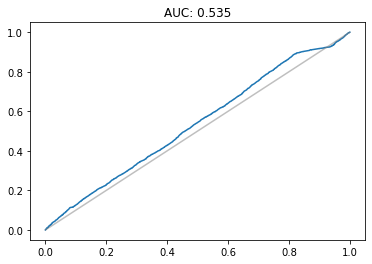

In [39]:
fraud_train = {"FraudInd": labels["Labelled"].values[:train_set_size]}
fraudMat_train = pd.DataFrame(fraud_train)
test_set_fraud = {"FraudInd": [0]*test_set_size}
fraudMat_test_set = pd.DataFrame(test_set_fraud)
fraudMat_test = fraudMat_train.append(fraudMat_test_set)

ADJ = adjmat_bipartite.transpose().tocsr()
Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, claim_nodes, party_nodes, fraudMat_test)

y = labels[train_set_size:].Labelled.values
pred = Claims_res.sort_values("ID")[train_set_size:].ScaledScore
fpr, tpr, thresholds = metrics.roc_curve(y,pred)
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr, tpr),3)))

In [40]:
Claims_res.sort_values("ID")[train_set_size:]

,ID,Score,StdScore,ScaledScore
227787,227787,1.129715e-06,-0.177184,0.015143
227788,227788,1.657672e-06,-0.083221,0.022220
227789,227789,6.860867e-07,-0.256139,0.009196
227790,227790,5.280911e-07,-0.284259,0.007079
227791,227791,4.880848e-08,-0.369559,0.000654
...,...,...,...,...
379640,379640,9.410981e-07,-0.210753,0.012615
379641,379641,8.026796e-07,-0.235388,0.010759
379642,379642,5.226053e-07,-0.285235,0.007005
379643,379643,2.557643e-06,0.076952,0.034283


# Leave-one-out cross validation

In [41]:
fraud = {"FraudInd": labels["Fraud"].values}
fraudMat = pd.DataFrame(fraud)

claim_nodes = pd.DataFrame({"ID": HG_claims}).set_index("ID")
claim_nodes_index = claim_nodes.copy()
claim_nodes_index["Index"] = range(len(claim_nodes))

HG_parties = np.concatenate((HG_cars, HG_policies, HG_brokers))
party_nodes = pd.DataFrame({"ID": HG_parties}).set_index("ID")

ADJ = adjmat_bipartite.tocsr()
number_claims = ADJ.shape[0]
test_set_size = 200

#test_set = claim_nodes.sample(test_set_size, random_state=1997)

In [42]:
test_set_fraud = fraudMat[fraudMat["FraudInd"]==1].sample(int(test_set_size/2), random_state = 1997)
test_set_nonfraud = fraudMat[fraudMat["FraudInd"]==0].sample(int(test_set_size/2), random_state = 1997)
test_set_all_index = list(test_set_fraud.index)+list(test_set_nonfraud.index)
len(test_set_all_index)

200

In [43]:
test_set = claim_nodes.iloc[test_set_all_index]

In [36]:
y_true = []
y_predict = []

for claim in tqdm(test_set.index):
    train_set_boolian = (claim_nodes.index!=claim)
    ADJ_train= ADJ[train_set_boolian, :]
    fraud_train = {"FraudInd": labels["Fraud"].values[train_set_boolian]}
    fraudMat_train = pd.DataFrame(fraud_train)
    claims_train = claim_nodes[train_set_boolian]

    ADJ_train = ADJ_train.transpose().tocsr()
    Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ_train, claims_train, party_nodes, fraudMat_train)
    
    fraud_train_res = pd.DataFrame({"Index":Claims_res["ID"].values, "FraudInd": Claims_res["ScaledScore"].values})
    full_test_scores =fraud_train_res.merge(claim_nodes_index.reset_index(), on = "Index", how = "outer").fillna(0)
    fraudMat_test = full_test_scores.sort_values("ID")[["FraudInd"]]
    
    ADJ = adjmat_bipartite.transpose().tocsr()
    Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, claim_nodes, party_nodes, fraudMat_test)
    
    y = labels[claim_nodes.index==claim].Fraud.values
    pred = Claims_res.loc[claim_nodes.index==claim].ScaledScore
    y_true.append(y[0])
    y_predict.append(pred.iloc[0])
    

  0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.
Convergence reached.


C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:7: RuntimeWarning: divide by zero encountered in true_divide
  Dc = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=0))), [0])


Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence r

Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.


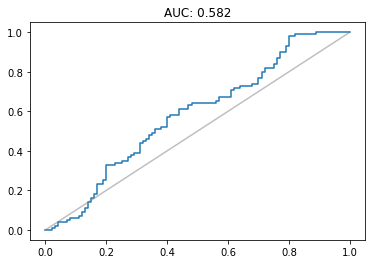

In [37]:
fpr, tpr, thresholds = metrics.roc_curve(y_true,y_predict)
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr, tpr),3)))
plt.savefig("LOOCV_5050_connected.pdf")

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_true, y_predict)
plt.plot(recall,precision)
plt.title("Average Precision: "+str(np.round(metrics.average_precision_score(y, pred),3)))

# Tuning Alpha

In [38]:
AUCs = []
alphas = np.arange(0.05, 1, 0.05)


party_nodes = pd.DataFrame({"ID": HG_parties}).set_index("ID")
claim_nodes = pd.DataFrame({"ID": HG_claims}).set_index("ID")

ADJ = adjmat_bipartite.tocsr()
number_claims = ADJ.shape[0]
train_set_size = int(np.round(0.6*number_claims)) #Full training set for validation
ADJ= ADJ[:train_set_size,:]
claim_nodes_val = claim_nodes[:train_set_size]
labels_val = labels[:train_set_size]

number_claims = ADJ.shape[0]
train_set_size = int(np.round(0.6*number_claims))
test_set_size = number_claims-train_set_size #validation set
ADJ_train= ADJ[:train_set_size,:]
fraud_train = {"FraudInd": labels["Fraud"].values[:train_set_size]}
fraudMat_train = pd.DataFrame(fraud_train)
claims_train = claim_nodes_val[:train_set_size]

ADJ_val_train = ADJ_train.transpose().tocsr()
ADJ_val_test = ADJ.transpose().tocsr()

for alpha in tqdm(alphas):
    Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ_val_train, claims_train, party_nodes, fraudMat_train, alpha = alpha)

    fraud_train_res = {"FraudInd": Claims_res.sort_values("ID")["ScaledScore"].values}
    test_set_fraud = {"FraudInd": [0]*test_set_size}
    fraudMat_train_res = pd.DataFrame(fraud_train_res)
    fraudMat_test_set = pd.DataFrame(test_set_fraud)
    fraudMat_test = fraudMat_train_res.append(fraudMat_test_set)
    
    Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ_val_test, claim_nodes_val, party_nodes, fraudMat_test, alpha = alpha)
    
    y = labels_val[train_set_size:].Fraud.values
    pred = Claims_res.sort_values("ID")[train_set_size:].ScaledScore
    fpr, tpr, thresholds = metrics.roc_curve(y,pred)
    AUC = metrics.auc(fpr, tpr)
    AUCs.append(AUC)

  0%|          | 0/19 [00:00<?, ?it/s]

C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.
Convergence reached.


C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.
Convergence reached.


C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.
Convergence reached.


C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.
Convergence reached.


C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.
Convergence reached.


C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.
Convergence reached.


C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.
Convergence reached.


C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.
Convergence reached.


C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.
Convergence reached.


C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.
Convergence reached.


C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.
Convergence reached.


C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.
Convergence reached.


C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.
Convergence reached.


C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.
Convergence reached.


C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.
Convergence reached.


C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.
Convergence reached.


C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.
Convergence reached.


C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.
Convergence reached.


C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.
Convergence reached.


In [39]:
alpha_maxAUC = alphas[AUCs.index(max(AUCs))]
print(alpha_maxAUC)

0.3


C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.
Convergence reached.


Text(0.5, 1.0, 'AUC: 0.527')

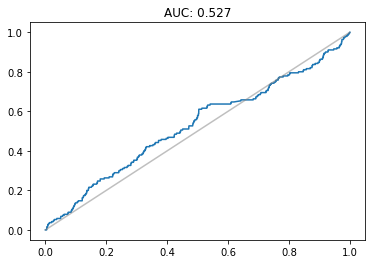

In [40]:
ADJ = adjmat_bipartite.tocsr()
number_claims = ADJ.shape[0]
train_set_size = int(np.round(0.6*number_claims))
test_set_size = number_claims-train_set_size
ADJ_train= ADJ[:train_set_size,:]
fraud_train = {"FraudInd": labels["Fraud"].values[:train_set_size]}
fraudMat_train = pd.DataFrame(fraud_train)
claims_train = claim_nodes[:train_set_size]

ADJ = ADJ_train.transpose().tocsr()
Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, claims_train, party_nodes, fraudMat_train, alpha = alpha_maxAUC)

fraud_train_res = {"FraudInd": Claims_res.sort_values("ID")["ScaledScore"].values}
test_set_fraud = {"FraudInd": [0]*test_set_size}
fraudMat_train_res = pd.DataFrame(fraud_train_res)
fraudMat_test_set = pd.DataFrame(test_set_fraud)
fraudMat_test = fraudMat_train_res.append(fraudMat_test_set)

ADJ = adjmat_bipartite.transpose().tocsr()
Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, claim_nodes, party_nodes, fraudMat_test, alpha = alpha_maxAUC)

y = labels[train_set_size:].Fraud.values
pred = Claims_res.sort_values("ID")[train_set_size:].ScaledScore
fpr, tpr, thresholds = metrics.roc_curve(y,pred)

plt.plot(fpr,tpr)


plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr, tpr),3)))
#plt.savefig("AUC_Inductive_Alpha04.pdf")

In [ ]:
precision, recall, thresholds = precision_recall_curve(y, pred)
plt.plot(recall,precision)
plt.title("Average Precision: "+str(np.round(metrics.average_precision_score(y, pred),3)))